<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">Import libraries</h1>


In [1]:
from wordcloud import WordCloud
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install neattext
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data=pd.read_csv("drive/MyDrive/twitter-suicidal_data.csv")
data.head()

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


In [4]:
data['intention'].value_counts()

0    5121
1    3998
Name: intention, dtype: int64

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">DATA-SET SPLIT</h1>


In [5]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">DATA VISUALISATIONS</h1>


In [6]:
train_data['intention'].value_counts().index.values

array([0, 1])

In [7]:
plx.bar(train_data,x=train_data['intention'].value_counts().index.values,
        y=train_data['intention'].value_counts(),color=['Non-SUICIDE','SUICIDE'])

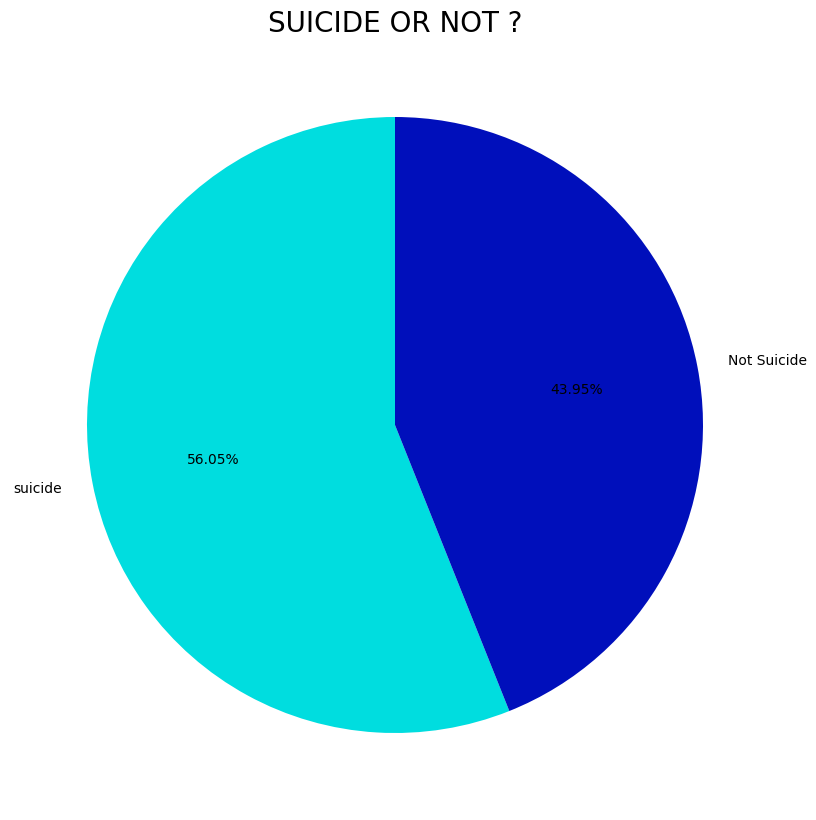

In [8]:
plt.figure(figsize=(12,10))
plt.pie(train_data['intention'].value_counts(),startangle=90,colors=['#00dddf','#000fbb'],
        autopct='%0.2f%%',labels=['suicide','Not Suicide'])
plt.title('SUICIDE OR NOT ?',fontdict={'size':20})
plt.show()

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">DATA CLEANING</h1>


In [9]:

def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_punctuations(sent)
        sent=nfx.remove_puncts(sent)
        sent=nfx.remove_stopwords(sent)
        sent=nfx.fix_contractions(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [10]:
train_data

,tweet,intention
5184,almost happened to me today lol,0
5469,good morning world i feel like shit but i have...,0
2208,because i cant get a hold of a gun or pillsi a...,1
1231,idk help i guess can someone talk to me or wat...,1
1775,i dont want to do this anymorei am so tired i ...,1
...,...,...
4829,no im still not sleeing good i know ive misse...,0
7291,consists of going from failure to failure with...,0
1344,wanting to die i am not sure if this makes sen...,1
7293,it s all fun amp games until you re throwing ...,0


In [11]:
cleaned_train_text,train_text_length=clean_text(train_data.tweet)
cleaned_test_text,test_text_length=clean_text(test_data.tweet)

100%|██████████| 1824/1824 [00:00<00:00, 6411.69it/s]


In [12]:
train_data.tweet

5184                      almost happened to me today lol
5469    good morning world i feel like shit but i have...
2208    because i cant get a hold of a gun or pillsi a...
1231    idk help i guess can someone talk to me or wat...
1775    i dont want to do this anymorei am so tired i ...
                              ...                        
4829     no im still not sleeing good i know ive misse...
7291    consists of going from failure to failure with...
1344    wanting to die i am not sure if this makes sen...
7293     it s all fun amp games until you re throwing ...
1289    my mother birthed me only to kill me not direc...
Name: tweet, Length: 7295, dtype: object

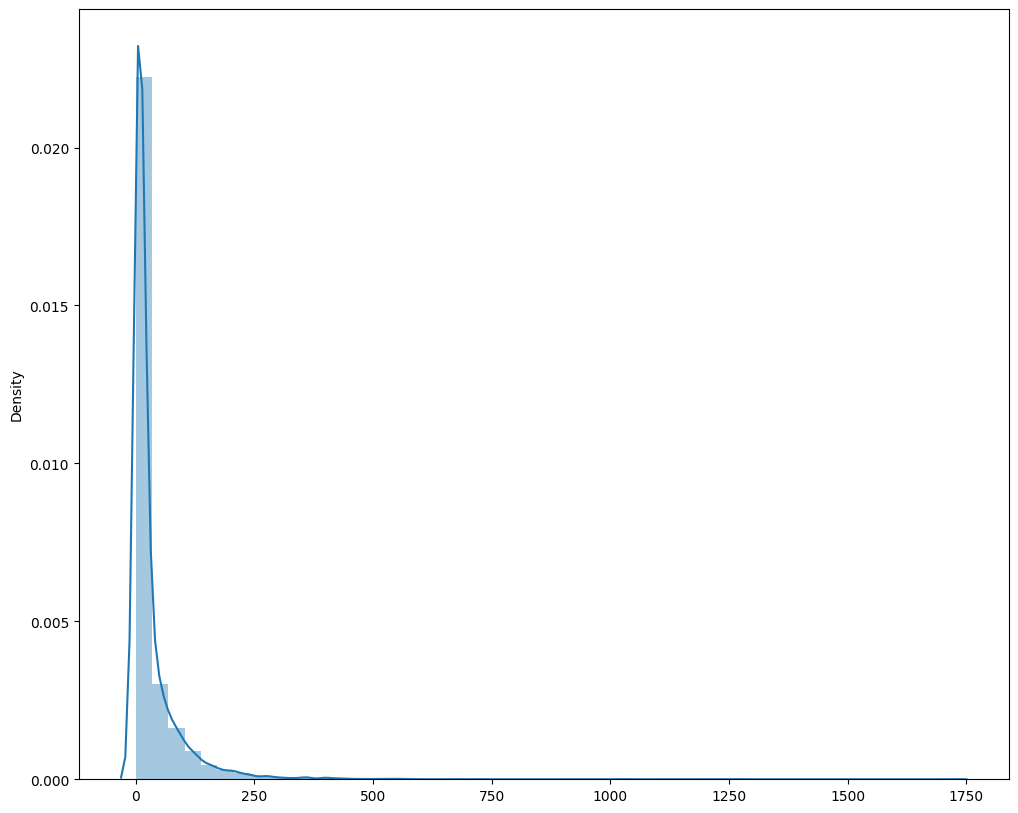

In [13]:
plt.figure(figsize=(12,10))
sns.distplot(train_text_length)
# plt.axis([-10,100,0,0.03])
plt.show()

In [14]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [15]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

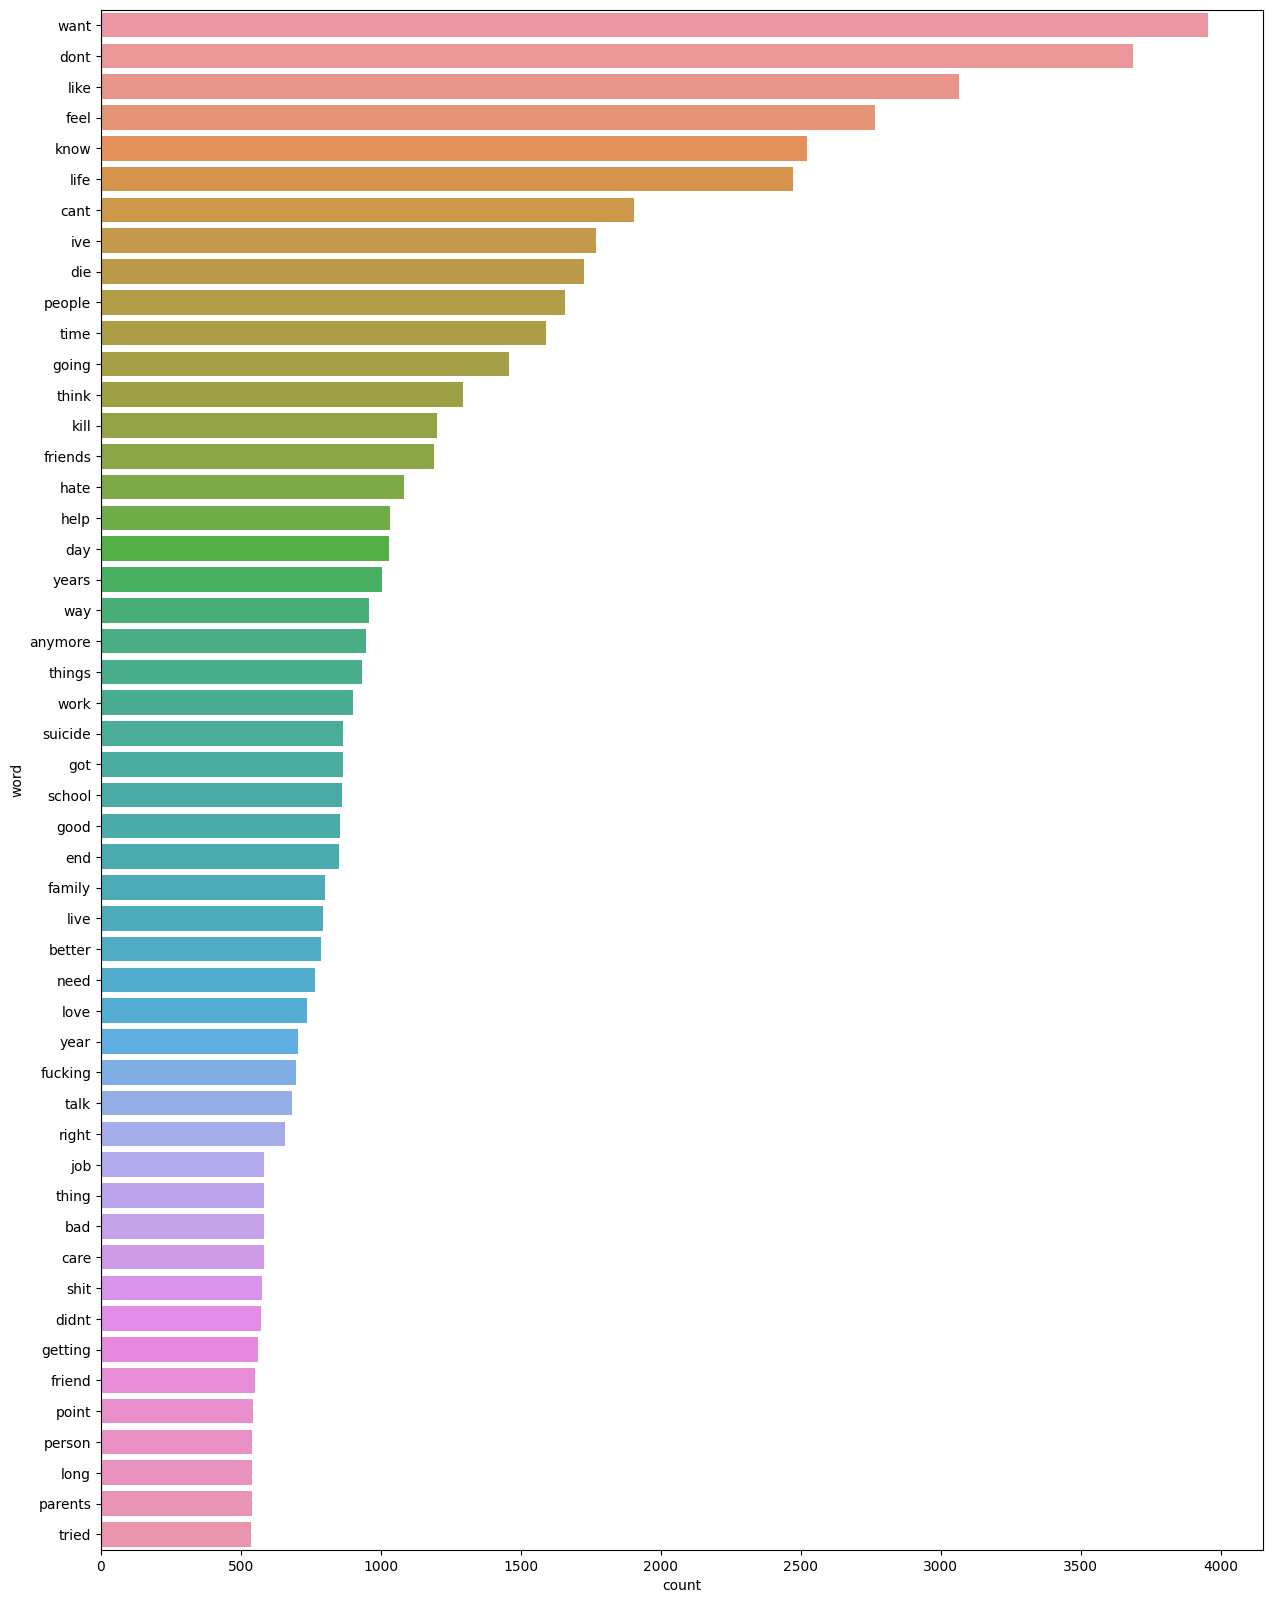

In [16]:
plt.figure(figsize=(15,20))
sns.barplot(x='count',y='word',data=word_freq.iloc[:50])
plt.show()

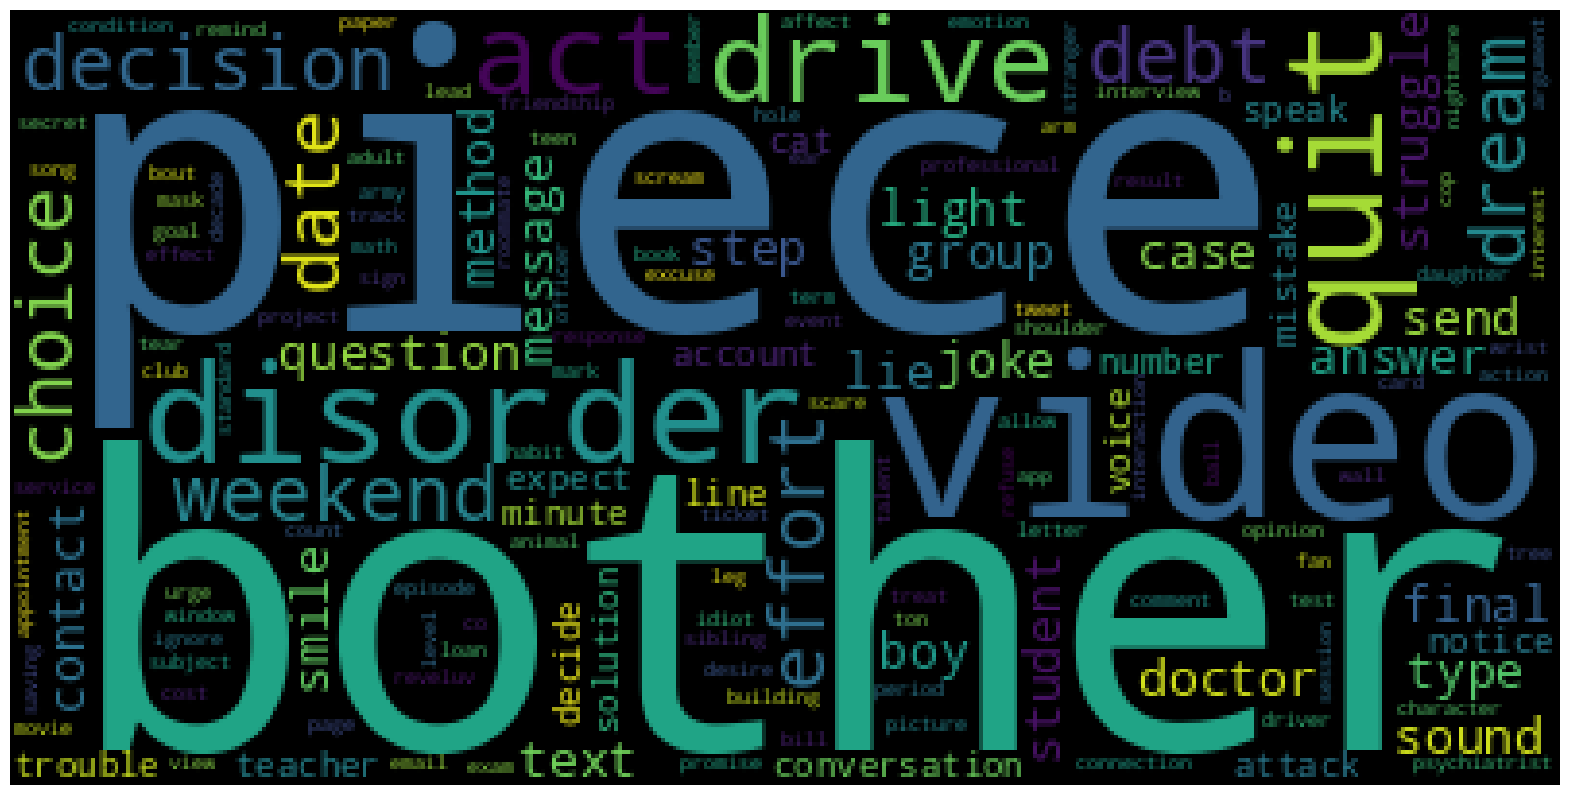

In [17]:
feature_names=word_freq['word'].values
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">PREPROCESSING TEXT DATA</h1>


In [18]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=300)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=300)

In [19]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['intention'])
test_output=lbl_target.transform(test_data['intention'])

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">GLOVE EMBEDDINGS</h1>


In [20]:
# pip install kaggle

In [21]:
# !mkdir -p ~/.kaggle
# !cp drive/MyDrive/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json


In [22]:
# !kaggle datasets download -d sugataghosh/google-word2vec

In [23]:
# !unzip google-word2vec.zip

In [24]:
# from gensim.models import KeyedVectors

# model_path = '/content/GoogleNews-vectors-negative300.bin'
# word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)


In [25]:
import gensim.downloader as api
import torch
import torch.nn as nn

word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [26]:
word2vec_model.get_mean_vector("didnt")

array([-5.3488255e-02,  4.2668302e-02, -7.2023422e-03,  6.4129367e-02,
       -5.7538677e-02,  1.0978194e-02, -2.5540018e-02, -3.3972733e-02,
       -5.1374035e-03,  6.0721408e-03, -7.1844384e-03, -4.7635645e-02,
       -8.6804375e-02,  1.8016577e-03, -4.3791004e-02,  2.2774460e-02,
        5.4100048e-02,  9.6573725e-02, -1.0948689e-02, -1.9644396e-02,
       -8.9057125e-02, -5.6218109e-03,  6.8838425e-02, -2.9621154e-02,
       -2.7561545e-02, -1.5649425e-02, -1.2639338e-01,  3.4483895e-02,
       -4.6201132e-02,  2.3430595e-02,  9.8260213e-03,  4.1742653e-02,
       -2.1938641e-02, -5.5213355e-02, -7.7106580e-02,  4.9401157e-02,
       -6.3044779e-02,  7.1210213e-02, -2.7512288e-02,  3.0963758e-02,
        1.1876280e-02, -1.8626040e-02,  3.1915717e-02,  1.7051397e-02,
        2.1789353e-02, -2.1867406e-02,  9.1836229e-03, -8.9146420e-02,
       -3.8061939e-02,  4.0096592e-02, -9.9097535e-02,  7.9211995e-02,
       -2.1011170e-02,  1.1535611e-01, -4.3768273e-03,  2.4481196e-02,
      

In [27]:

# Assuming you already have a tokenizer object named 'tokenizer'
v = len(tokenizer.word_index)

embedding_matrix = np.zeros((v + 1, 300), dtype=float)
for word, idx in tokenizer.word_index.items():
    embedding_vector = word2vec_model.get_mean_vector(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

In [28]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

#MODEL BUILDING


In [29]:
from tensorflow.keras.optimizers import Adam

model=Sequential()
model.add(Input(shape=(300,)))
model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(128,return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [30]:
r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=256,callbacks=[early_stop,reducelr])

Epoch 1/20
29/29 [==============================] - 9s 83ms/step - loss: 0.5068 - accuracy: 0.7904 - val_loss: 0.3749 - val_accuracy: 0.8410 - lr: 0.0010
Epoch 2/20
29/29 [==============================] - 1s 49ms/step - loss: 0.3839 - accuracy: 0.8292 - val_loss: 0.3504 - val_accuracy: 0.8481 - lr: 0.0010
Epoch 3/20
29/29 [==============================] - 1s 49ms/step - loss: 0.3656 - accuracy: 0.8344 - val_loss: 0.3379 - val_accuracy: 0.8520 - lr: 0.0010
Epoch 4/20
29/29 [==============================] - 1s 48ms/step - loss: 0.3695 - accuracy: 0.8317 - val_loss: 0.3502 - val_accuracy: 0.8476 - lr: 0.0010
Epoch 5/20
29/29 [==============================] - 1s 49ms/step - loss: 0.3591 - accuracy: 0.8384 - val_loss: 0.3380 - val_accuracy: 0.8514 - lr: 0.0010
Epoch 6/20
29/29 [==============================] - 1s 50ms/step - loss: 0.3535 - accuracy: 0.8433 - val_loss: 0.3443 - val_accuracy: 0.8498 - lr: 0.0010
Epoch 7/20
29/29 [==============================] - 1s 49ms/step - loss: 0.3

#MODEL EVALUATION


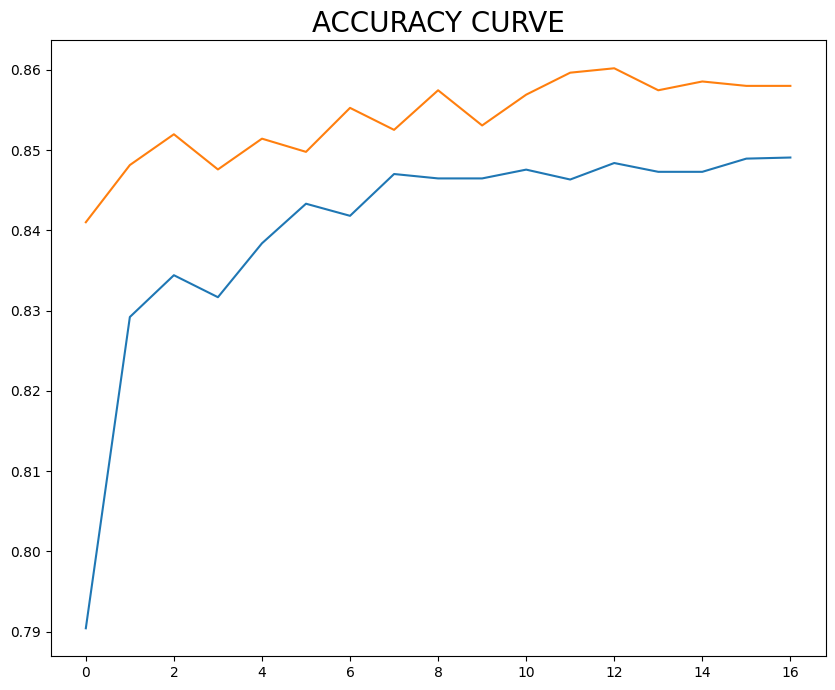

In [31]:
plt.figure(figsize=(10,8))
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

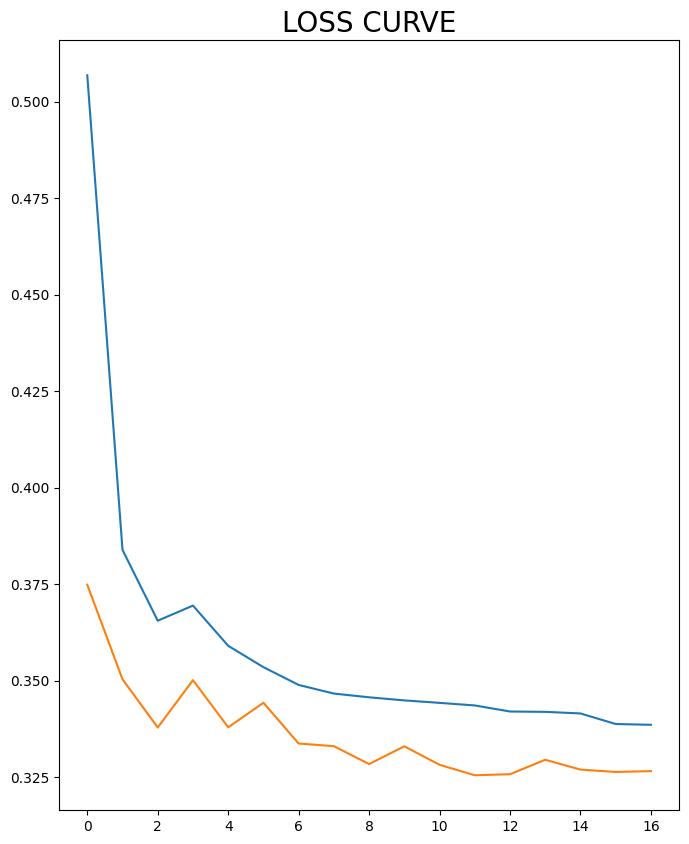

In [32]:
plt.figure(figsize=(8,10))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

In [33]:
from sklearn.metrics import classification_report

test_predictions = (model.predict(test_text_pad) > 0.5).astype(int)
train_predictions = (model.predict(train_text_pad) > 0.5).astype(int)


print('TESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(test_output, test_predictions, target_names=['Suicide', 'Non Suicide']))

print('TRAINING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(train_output, train_predictions, target_names=['Suicide', 'Non Suicide']))


228/228 [==============================] - 3s 8ms/step
TESTING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

     Suicide       0.81      0.99      0.89      1032
 Non Suicide       0.97      0.69      0.81       792

    accuracy                           0.86      1824
   macro avg       0.89      0.84      0.85      1824
weighted avg       0.88      0.86      0.85      1824

TRAINING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

     Suicide       0.80      0.97      0.88      4089
 Non Suicide       0.95      0.69      0.80      3206

    accuracy                           0.85      7295
   macro avg       0.88      0.83      0.84      7295
weighted avg       0.87      0.85      0.84      7295



#2-layer LSTM

In [36]:
model2=Sequential()
model2.add(Input(shape=(300,)))
model2.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model2.add(LSTM(128,return_sequences=True))
model2.add(LSTM(128,return_sequences=True))


model2.add(GlobalMaxPooling1D())
model2.add(Dense(256,activation='relu'))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [37]:
r2=model2.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=10,batch_size=256,callbacks=[early_stop,reducelr])

Epoch 1/10
29/29 [==============================] - 8s 105ms/step - loss: 0.4669 - accuracy: 0.7778 - val_loss: 0.3708 - val_accuracy: 0.8448 - lr: 0.0010
Epoch 2/10
29/29 [==============================] - 2s 76ms/step - loss: 0.3713 - accuracy: 0.8304 - val_loss: 0.3442 - val_accuracy: 0.8498 - lr: 0.0010
Epoch 3/10
29/29 [==============================] - 2s 77ms/step - loss: 0.3722 - accuracy: 0.8326 - val_loss: 0.3520 - val_accuracy: 0.8465 - lr: 0.0010
Epoch 4/10
29/29 [==============================] - 2s 81ms/step - loss: 0.3639 - accuracy: 0.8377 - val_loss: 0.3434 - val_accuracy: 0.8487 - lr: 0.0010
Epoch 5/10
29/29 [==============================] - 2s 81ms/step - loss: 0.3646 - accuracy: 0.8373 - val_loss: 0.3492 - val_accuracy: 0.8448 - lr: 0.0010
Epoch 6/10
29/29 [==============================] - 2s 77ms/step - loss: 0.3594 - accuracy: 0.8377 - val_loss: 0.3504 - val_accuracy: 0.8295 - lr: 0.0010
Epoch 7/10
29/29 [==============================] - 2s 77ms/step - loss: 0.

#MODEL EVALUATION


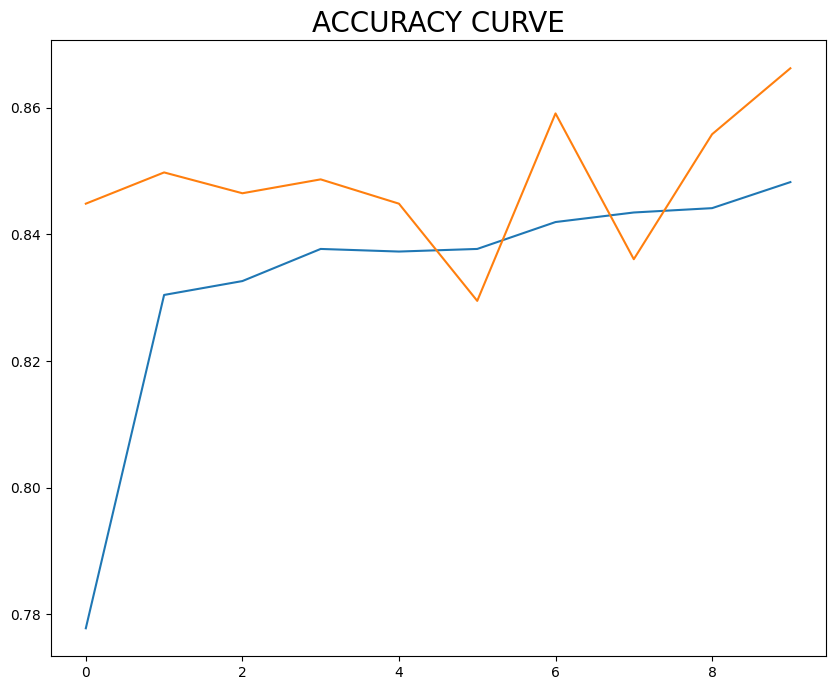

In [38]:
plt.figure(figsize=(10,8))
plt.plot(r2.history['accuracy'])
plt.plot(r2.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

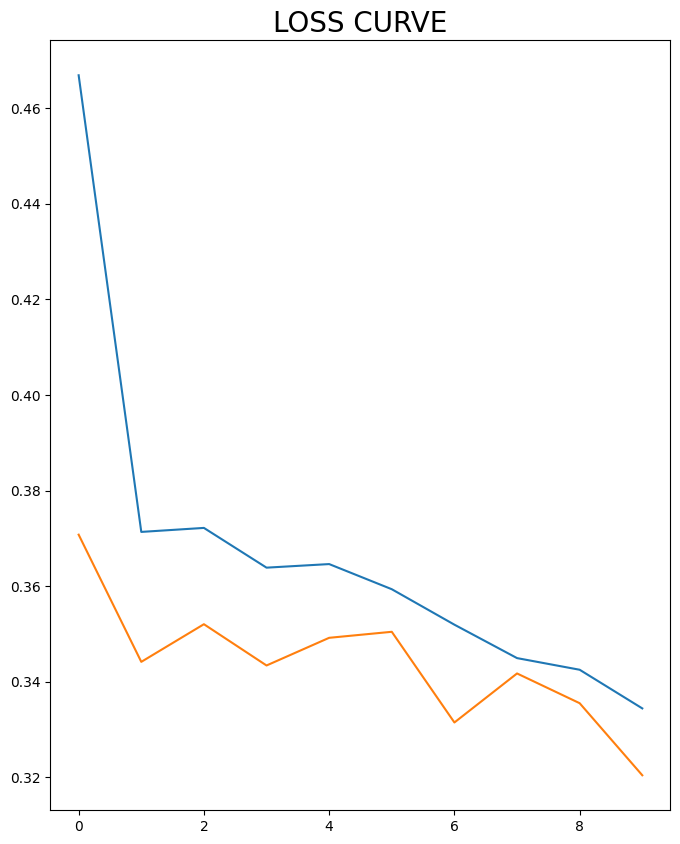

In [39]:
plt.figure(figsize=(8,10))
plt.plot(r2.history['loss'])
plt.plot(r2.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

In [40]:
from sklearn.metrics import classification_report

test_predictions = (model2.predict(test_text_pad) > 0.5).astype(int)
train_predictions = (model2.predict(train_text_pad) > 0.5).astype(int)


print('TESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(test_output, test_predictions, target_names=['Suicide', 'Non Suicide']))

print('TRAINING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(train_output, train_predictions, target_names=['Suicide', 'Non Suicide']))


228/228 [==============================] - 3s 9ms/step
TESTING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

     Suicide       0.83      0.96      0.89      1032
 Non Suicide       0.94      0.74      0.83       792

    accuracy                           0.87      1824
   macro avg       0.88      0.85      0.86      1824
weighted avg       0.88      0.87      0.86      1824

TRAINING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

     Suicide       0.82      0.94      0.88      4089
 Non Suicide       0.91      0.74      0.82      3206

    accuracy                           0.85      7295
   macro avg       0.87      0.84      0.85      7295
weighted avg       0.86      0.85      0.85      7295



#CNN + 2 layer LSTM

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, LSTM, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import Adam

# Assuming 'v', 'embedding_matrix', and other parameters are defined
# Adjust 'input_length' based on your actual input sequence length

model3 = Sequential()

# CNN layer
model3.add(Input(shape=(300,)))
model3.add(Embedding(v+1, 300, weights=[embedding_matrix], trainable=False))
model3.add(Conv1D(300, kernel_size=3, activation='relu'))

# 2-layer LSTM
model3.add(LSTM(128, return_sequences=True))
model3.add(LSTM(128, return_sequences=True))

model3.add(GlobalMaxPooling1D())
model3.add(Dense(256, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [42]:
r3=model3.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=256,callbacks=[early_stop,reducelr])

Epoch 1/20
29/29 [==============================] - 12s 153ms/step - loss: 0.4663 - accuracy: 0.7757 - val_loss: 0.3481 - val_accuracy: 0.8454 - lr: 0.0010
Epoch 2/20
29/29 [==============================] - 3s 111ms/step - loss: 0.3687 - accuracy: 0.8317 - val_loss: 0.3402 - val_accuracy: 0.8536 - lr: 0.0010
Epoch 3/20
29/29 [==============================] - 3s 112ms/step - loss: 0.3680 - accuracy: 0.8328 - val_loss: 0.3378 - val_accuracy: 0.8547 - lr: 0.0010
Epoch 4/20
29/29 [==============================] - 3s 113ms/step - loss: 0.3613 - accuracy: 0.8378 - val_loss: 0.3346 - val_accuracy: 0.8547 - lr: 0.0010
Epoch 5/20
29/29 [==============================] - 3s 115ms/step - loss: 0.3549 - accuracy: 0.8406 - val_loss: 0.3325 - val_accuracy: 0.8640 - lr: 0.0010
Epoch 6/20
29/29 [==============================] - 3s 111ms/step - loss: 0.3530 - accuracy: 0.8451 - val_loss: 0.3375 - val_accuracy: 0.8613 - lr: 0.0010
Epoch 7/20
29/29 [==============================] - 3s 111ms/step - l

#MODEL EVALUATION


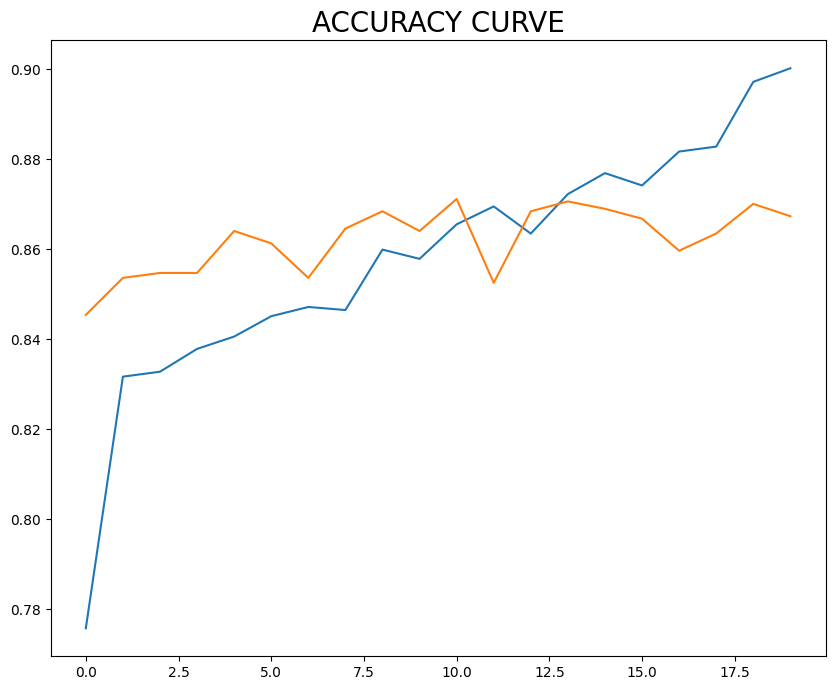

In [43]:
plt.figure(figsize=(10,8))
plt.plot(r3.history['accuracy'])
plt.plot(r3.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

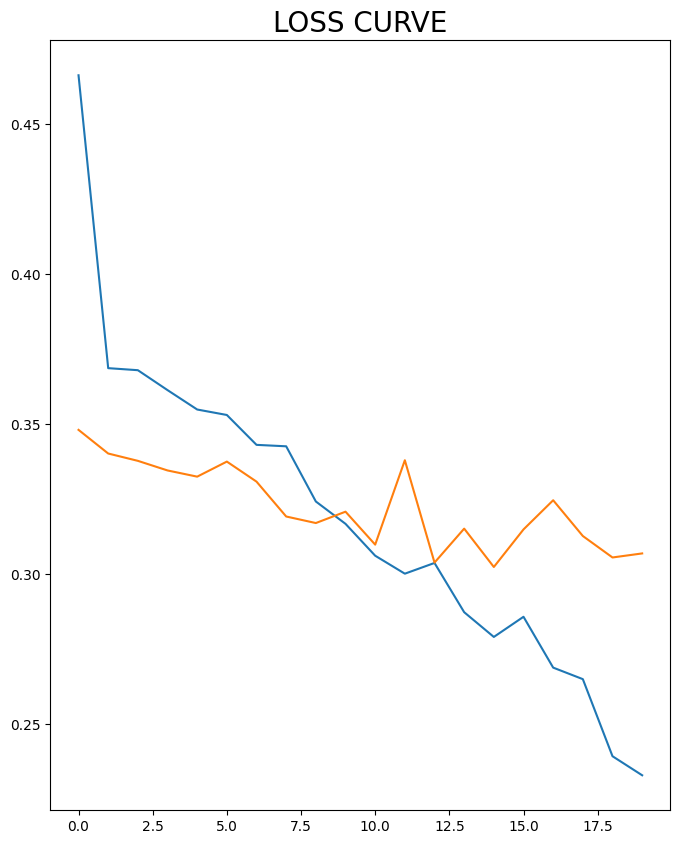

In [44]:
plt.figure(figsize=(8,10))
plt.plot(r3.history['loss'])
plt.plot(r3.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

In [45]:
from sklearn.metrics import classification_report

test_predictions = (model3.predict(test_text_pad) > 0.5).astype(int)
train_predictions = (model3.predict(train_text_pad) > 0.5).astype(int)


print('TESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(test_output, test_predictions, target_names=['Suicide', 'Non Suicide']))

print('TRAINING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(train_output, train_predictions, target_names=['Suicide', 'Non Suicide']))


228/228 [==============================] - 4s 13ms/step
TESTING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

     Suicide       0.86      0.92      0.89      1032
 Non Suicide       0.88      0.80      0.84       792

    accuracy                           0.87      1824
   macro avg       0.87      0.86      0.86      1824
weighted avg       0.87      0.87      0.87      1824

TRAINING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

     Suicide       0.89      0.94      0.91      4089
 Non Suicide       0.92      0.85      0.88      3206

    accuracy                           0.90      7295
   macro avg       0.90      0.90      0.90      7295
weighted avg       0.90      0.90      0.90      7295

